In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
config = tf.compat.v1.ConfigProto(log_device_placement=True,
inter_op_parallelism_threads=0,
intra_op_parallelism_threads=0,
allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1



Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


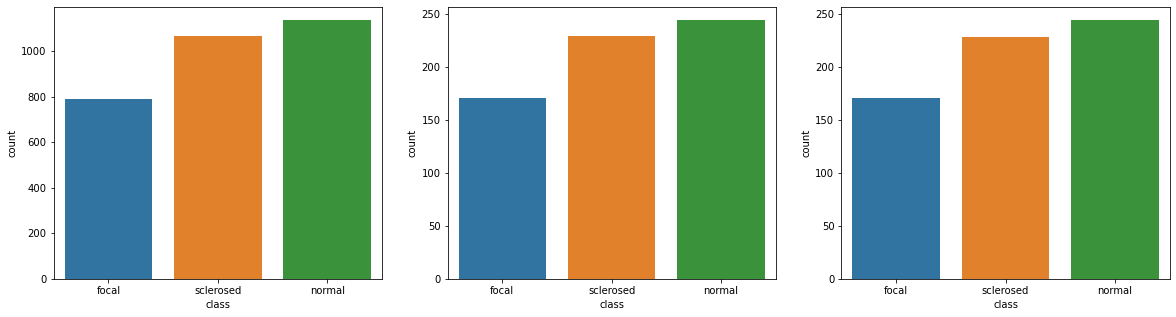

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
IMG_SIZE = 256

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

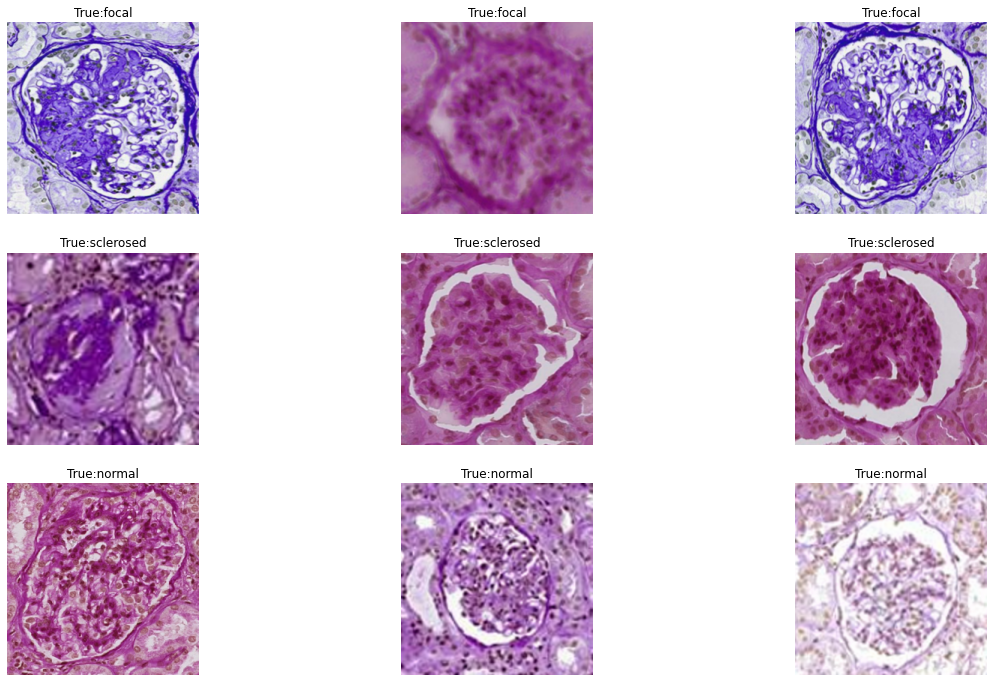

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights=None, include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
2993/2993 [==============================] - 79s 23ms/step - loss: 1.0988 - acc: 0.3879 - val_loss: 0.9816 - val_acc: 0.4673
Epoch 2/30
2993/2993 [==============================] - 67s 22ms/step - loss: 1.0082 - acc: 0.4487 - val_loss: 0.9413 - val_acc: 0.5140
Epoch 3/30
2993/2993 [==============================] - 67s 22ms/step - loss: 0.9570 - acc: 0.5065 - val_loss: 0.8691 - val_acc: 0.6012
Epoch 4/30
2993/2993 [==============================] - 67s 22ms/step - loss: 0.9049 - acc: 0.5536 - val_loss: 0.8391 - val_acc: 0.6480
Epoch 5/30
2993/2993 [==============================] - 67s 22ms/step - loss: 0.8405 - acc: 0.5931 - val_loss: 0.7618 - val_acc: 0.6184
Epoch 6/30
2993/2993 [==============================] - 67s 22ms/step - loss: 0.8080 - acc: 0.6213 - val_loss: 0.7207 - val_acc: 0.6978
Epoch 7/30
2993/2993 [==============================] - 64s 21ms/step - loss: 0.7810 - acc: 0.6447 - 

[0.4564877152442932, 0.8102644085884094]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
1497/1497 [==============================] - 76s 42ms/step - loss: 0.4802 - acc: 0.8062 - val_loss: 0.4403 - val_acc: 0.8427
Epoch 2/30
1497/1497 [==============================] - 60s 40ms/step - loss: 0.4761 - acc: 0.8019 - val_loss: 0.6589 - val_acc: 0.7259
Epoch 3/30
1497/1497 [==============================] - 60s 40ms/step - loss: 0.4663 - acc: 0.8186 - val_loss: 0.4250 - val_acc: 0.8333
Epoch 4/30
1497/1497 [==============================] - 60s 40ms/step - loss: 0.4753 - acc: 0.8092 - val_loss: 0.4193 - val_acc: 0.8474
Epoch 5/30
1497/1497 [==============================] - 59s 39ms/step - loss: 0.4750 - acc: 0.8102 - val_loss: 0.4252 - val_acc: 0.8427
Epoch 6/30
1497/1497 [==============================] - 61s 40ms/step - loss: 0.4769 - acc: 0.8072 - val_loss: 0.4056 - val_acc: 0.8505
Epoch 7/30
1497/1497 [==============================] - 62s 41ms/step - loss: 0.4777 - acc: 0.8015 - 

[0.3966316282749176, 0.8304821252822876]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(4)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
749/749 [==============================] - 36s 38ms/step - loss: 1.0752 - acc: 0.4064 - val_loss: 0.9823 - val_acc: 0.5016
Epoch 2/10
749/749 [==============================] - 20s 26ms/step - loss: 0.9690 - acc: 0.5080 - val_loss: 0.8793 - val_acc: 0.6012
Epoch 3/10
749/749 [==============================] - 20s 26ms/step - loss: 0.9088 - acc: 0.5518 - val_loss: 0.8066 - val_acc: 0.6090
Epoch 4/10
749/749 [==============================] - 20s 26ms/step - loss: 0.8028 - acc: 0.6366 - val_loss: 0.7905 - val_acc: 0.5467
Epoch 5/10
749/749 [==============================] - 20s 27ms/step - loss: 0.7509 - acc: 0.6659 - val_loss: 0.6531 - val_acc: 0.7383
Epoch 6/10
749/749 [==============================] - 20s 26ms/step - loss: 0.6828 - acc: 0.7078 - val_loss: 0.6427 - val_acc: 0.7352
Epoch 7/10
749/749 [==============================] - 15s 20ms/step - loss: 0.6254 - acc: 0.7264 - val_loss: 0.61

[0.5293679237365723, 0.7807154059410095]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(8)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
375/375 [==============================] - 27s 48ms/step - loss: 0.5435 - acc: 0.7818 - val_loss: 0.5505 - val_acc: 0.7788
Epoch 2/10
375/375 [==============================] - 13s 35ms/step - loss: 0.5403 - acc: 0.7788 - val_loss: 0.5434 - val_acc: 0.7695
Epoch 3/10
375/375 [==============================] - 13s 35ms/step - loss: 0.5291 - acc: 0.7855 - val_loss: 0.5481 - val_acc: 0.7757
Epoch 4/10
375/375 [==============================] - 13s 35ms/step - loss: 0.5259 - acc: 0.7731 - val_loss: 0.5422 - val_acc: 0.7850
Epoch 5/10
375/375 [==============================] - 18s 48ms/step - loss: 0.5259 - acc: 0.7808 - val_loss: 0.5644 - val_acc: 0.7726
Epoch 6/10
375/375 [==============================] - 13s 35ms/step - loss: 0.5288 - acc: 0.7815 - val_loss: 0.4856 - val_acc: 0.8084
Epoch 7/10
375/375 [==============================] - 13s 35ms/step - loss: 0.4978 - acc: 0.7979 - val_loss: 0.53

[0.49306562542915344, 0.7776049971580505]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(16)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
188/188 [==============================] - 22s 61ms/step - loss: 0.4726 - acc: 0.8129 - val_loss: 0.5471 - val_acc: 0.7882
Epoch 2/10
188/188 [==============================] - 12s 61ms/step - loss: 0.4869 - acc: 0.8082 - val_loss: 0.4742 - val_acc: 0.8069
Epoch 3/10
188/188 [==============================] - 12s 61ms/step - loss: 0.4784 - acc: 0.8156 - val_loss: 0.4553 - val_acc: 0.8224
Epoch 4/10
188/188 [==============================] - 12s 61ms/step - loss: 0.4671 - acc: 0.8159 - val_loss: 0.7505 - val_acc: 0.6371
Epoch 5/10
188/188 [==============================] - 12s 61ms/step - loss: 0.4798 - acc: 0.7992 - val_loss: 0.4230 - val_acc: 0.8723
Epoch 6/10
188/188 [==============================] - 17s 88ms/step - loss: 0.4621 - acc: 0.8196 - val_loss: 0.4194 - val_acc: 0.8474
Epoch 7/10
188/188 [==============================] - 12s 61ms/step - loss: 0.4690 - acc: 0.8116 - val_loss: 0.41

[0.4384306073188782, 0.8242612481117249]

In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(32)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
94/94 [==============================] - 35s 249ms/step - loss: 0.4414 - acc: 0.8326 - val_loss: 0.4547 - val_acc: 0.8193
Epoch 2/10
94/94 [==============================] - 13s 128ms/step - loss: 0.4452 - acc: 0.8276 - val_loss: 0.4189 - val_acc: 0.8427
Epoch 3/10
94/94 [==============================] - 13s 129ms/step - loss: 0.4470 - acc: 0.8196 - val_loss: 0.4952 - val_acc: 0.8037
Epoch 4/10
94/94 [==============================] - 13s 129ms/step - loss: 0.4419 - acc: 0.8269 - val_loss: 0.4315 - val_acc: 0.8255
Epoch 5/10
94/94 [==============================] - 13s 127ms/step - loss: 0.4411 - acc: 0.8259 - val_loss: 0.4151 - val_acc: 0.8427
Epoch 6/10
94/94 [==============================] - 13s 127ms/step - loss: 0.4355 - acc: 0.8309 - val_loss: 0.4362 - val_acc: 0.8193
Epoch 7/10
94/94 [==============================] - 13s 130ms/step - loss: 0.4448 - acc: 0.8266 - val_loss: 0.4265 - va

[0.4457564651966095, 0.8009331226348877]

In [16]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(64)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
47/47 [==============================] - 40s 550ms/step - loss: 0.4238 - acc: 0.8420 - val_loss: 0.4042 - val_acc: 0.8598
Epoch 2/10
47/47 [==============================] - 15s 290ms/step - loss: 0.4278 - acc: 0.8360 - val_loss: 0.3927 - val_acc: 0.8645
Epoch 3/10
47/47 [==============================] - 15s 291ms/step - loss: 0.4249 - acc: 0.8353 - val_loss: 0.3923 - val_acc: 0.8660
Epoch 4/10
47/47 [==============================] - 15s 289ms/step - loss: 0.4292 - acc: 0.8390 - val_loss: 0.4155 - val_acc: 0.8505
Epoch 5/10
47/47 [==============================] - 15s 296ms/step - loss: 0.4250 - acc: 0.8376 - val_loss: 0.3872 - val_acc: 0.8614
Epoch 6/10
47/47 [==============================] - 15s 300ms/step - loss: 0.4198 - acc: 0.8343 - val_loss: 0.4090 - val_acc: 0.8489
Epoch 7/10
47/47 [==============================] - 15s 295ms/step - loss: 0.4240 - acc: 0.8339 - val_loss: 0.3869 - va

[0.4241534173488617, 0.8195956349372864]

In [17]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(128)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
24/24 [==============================] - 30s 560ms/step - loss: 0.4157 - acc: 0.8403 - val_loss: 0.4245 - val_acc: 0.8364
Epoch 2/10
24/24 [==============================] - 17s 591ms/step - loss: 0.4171 - acc: 0.8403 - val_loss: 0.4082 - val_acc: 0.8474
Epoch 3/10
24/24 [==============================] - 18s 602ms/step - loss: 0.4111 - acc: 0.8456 - val_loss: 0.4074 - val_acc: 0.8536
Epoch 4/10
24/24 [==============================] - 19s 606ms/step - loss: 0.4102 - acc: 0.8490 - val_loss: 0.4422 - val_acc: 0.8349
Epoch 5/10
24/24 [==============================] - 18s 586ms/step - loss: 0.4169 - acc: 0.8430 - val_loss: 0.3997 - val_acc: 0.8536
Epoch 6/10
24/24 [==============================] - 18s 595ms/step - loss: 0.4109 - acc: 0.8463 - val_loss: 0.3914 - val_acc: 0.8629
Epoch 7/10
24/24 [==============================] - 19s 606ms/step - loss: 0.4107 - acc: 0.8430 - val_loss: 0.3955 - va

[0.4173988699913025, 0.8242612481117249]

In [18]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=1000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(256)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
12/12 [==============================] - 65s 4s/step - loss: 0.4106 - acc: 0.8403 - val_loss: 0.3916 - val_acc: 0.8614
Epoch 2/10
12/12 [==============================] - 19s 1s/step - loss: 0.4148 - acc: 0.8473 - val_loss: 0.4226 - val_acc: 0.8364
Epoch 3/10
12/12 [==============================] - 24s 1s/step - loss: 0.4083 - acc: 0.8440 - val_loss: 0.3817 - val_acc: 0.8676
Epoch 4/10
12/12 [==============================] - 23s 1s/step - loss: 0.4063 - acc: 0.8466 - val_loss: 0.4242 - val_acc: 0.8255
Epoch 5/10
12/12 [==============================] - 24s 1s/step - loss: 0.4117 - acc: 0.8527 - val_loss: 0.3992 - val_acc: 0.8505
Epoch 6/10
12/12 [==============================] - 23s 1s/step - loss: 0.4134 - acc: 0.8430 - val_loss: 0.3960 - val_acc: 0.8567
Epoch 7/10
12/12 [==============================] - 23s 1s/step - loss: 0.4104 - acc: 0.8486 - val_loss: 0.4051 - val_acc: 0.8442
Epoch 8

[0.41422632336616516, 0.8258165121078491]

In [ ]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(512)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10


In [ ]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(1024)
model.evaluate(data_test)

In [ ]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

data_test = test(2048)
model.evaluate(data_test)